# AdventureWorks - Försäljningsanalys  

I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Med hjälp av SQL hämtas data och för att visualisera och analysera resultatet används Python.

In [37]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import numpy as np

user = "SA"
password = quote_plus("Stoffe3836!")
server = 'localhost:1434'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\magda\AppData\Local\Temp\ipykernel_13824\499267134.py:23: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [38]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori? 

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

Plan:  
JOINA tabellerna  
Räkna DISTINCT produkter per kategori  
Skapa vertikalt stapeldiagram  
Analysera resultatet  

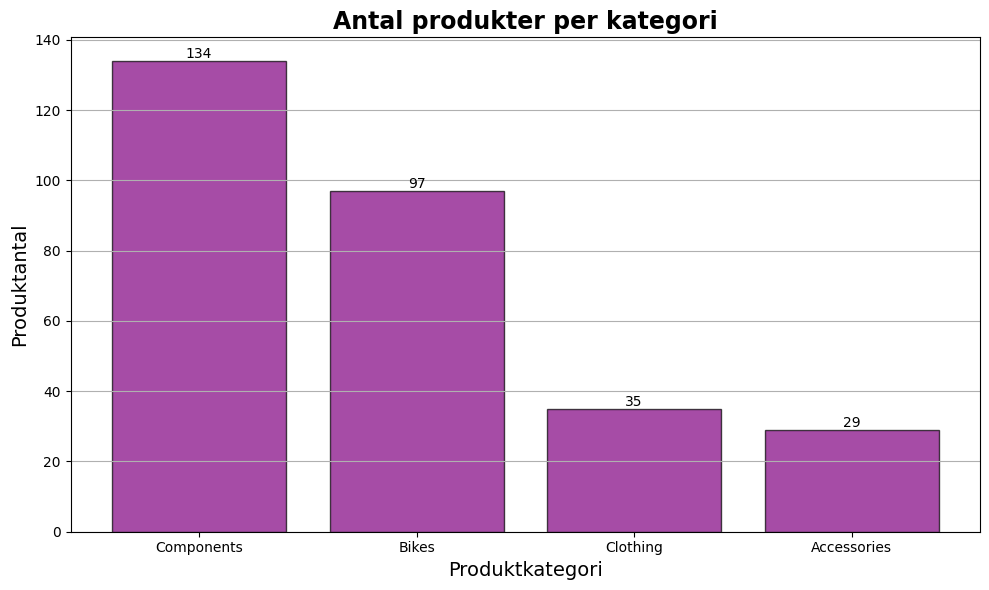

In [39]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize= (10,6))
bars = ax.bar(df_vis1["CategoryName"], df_vis1["ProductCount"], color="purple", alpha=0.7, edgecolor="black")

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

ax.set_xlabel("Produktkategori", fontsize=14)
ax.set_ylabel("Produktantal", fontsize=14)
ax.set_title("Antal produkter per kategori", fontsize=17, fontweight="bold")
ax.grid(True, axis="y")

plt.tight_layout()
plt.show()


### Analys - Antal produkter per kategori

Komponenter är den största kategorin med 134 produkter.  
Accessoarer är den minsta kategorin med endast 29 produkter.

Utifrån denna visualisering kan man se att komponenter utgör upp mot 50% av produkterna och det är här företaget har fokuserat mest.
Det kan vara en idé att marknadsföra accessoarer och kläder mer för att utöka antalet av dessa produkter.

## Visualisering 2 - Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

Tabeller som används:
- Production.ProductCategory 
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:  
JOINA tabellerna  
Räkna SUM av varje produktkategori  
ORDER BY högst till lägst försäljning  
Skapa Horisontellt stapeldiagram  
Analysera reslutatet  

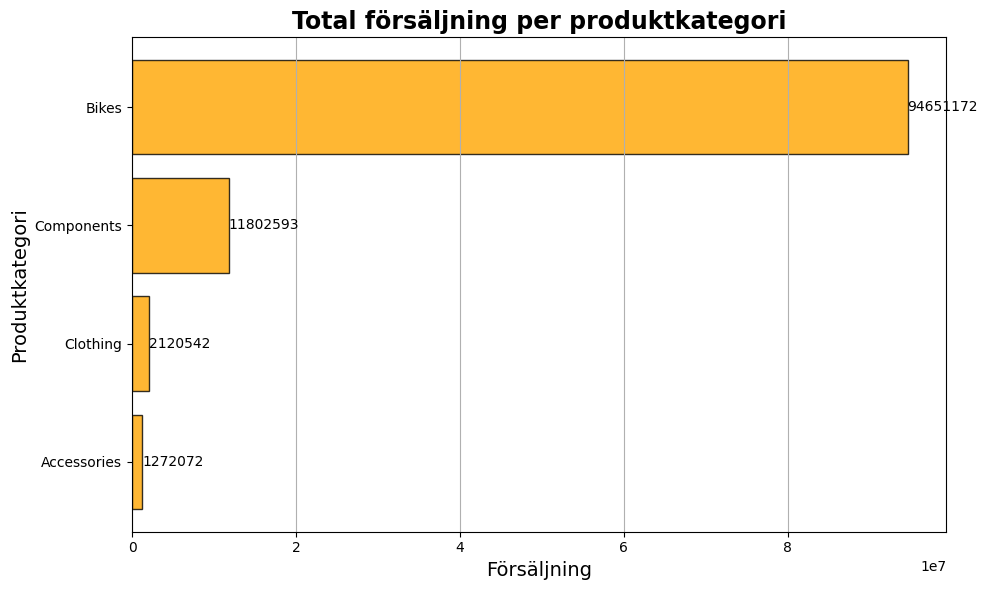

In [40]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalRevenue
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY TotalRevenue ASC
"""

df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(10,6))

h_bar = ax.barh(df_vis2["CategoryName"], df_vis2["TotalRevenue"], color="orange", edgecolor="black", alpha=0.8)

for bar in h_bar:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    ax.text(
        width,
        y,
        f"{int(width)}",
        va="center", 
        ha="left"
    )

ax.set_title("Total försäljning per produktkategori", fontsize=17, fontweight="bold")
ax.set_xlabel("Försäljning", fontsize=14)
ax.set_ylabel("Produktkategori", fontsize=14)
ax.grid(True, axis="x")
plt.tight_layout()
plt.show()


### Analys - Försäljning per produktkategori

Kategorin som har den högsta försäljningen i siffror är cyklar som ligger på totalt 94651172.704731.  
Kategorin med den lägsta försäljningen är accessoarer som ligger på 1272072.883926.


## Visualisering 3 - Försäljningstrend över tid
Hur har försäljningen utvecklats över tid?

Tabell som används:
- Sales.SalesOrderHeader

Plan
Aggregera per månad (minst 12 månader data)  
Sortera kronologiskt (äldst först)  
Skapa Linjediagram (line plot)  

• Beskriv trenden - ökar den, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.

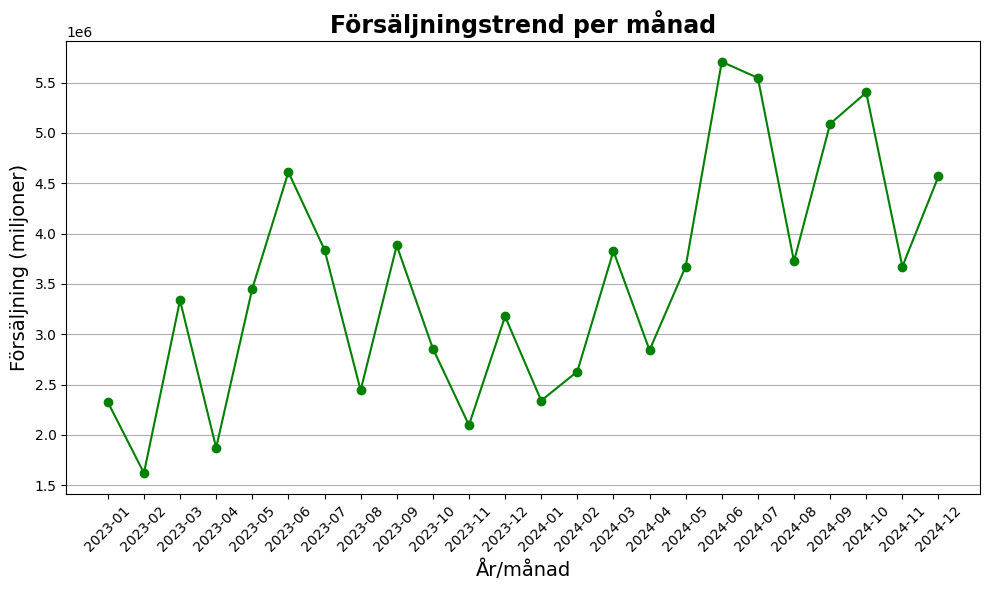

In [41]:
query_vis3 = """
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
WHERE OrderDate >= '2023-01-01'
AND OrderDate < '2025-01-01'
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY YearMonth ASC;
"""

df_vis3 = query_df(query_vis3)

fig, ax = plt.subplots(figsize=(10,6))
plot = ax.plot(df_vis3["YearMonth"], df_vis3["TotalSales"], marker="o", color="green")
ax.set_title("Försäljningstrend per månad", fontsize=17, fontweight="bold")
ax.set_xlabel("År/månad", fontsize=14)
ax.set_ylabel("Försäljning (miljoner)", fontsize=14)
ax.grid(True, axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analys - Försäljningstrend per månad

Jag har tagit ut försäljningen för 2023 och 2024 där man tydligt kan se att försäljningen ökat 2024 jämfört med 2023.    
Månaden med mest försäljning är juni 2024 och den med lägst är februari 2023.   
Man kan se att försäljningen ökar som mest under sommartid då även högsta försäljningsmånaden under 2023 var i juni.   

## Visualisering 4 - Försäljning och antal ordrar per år
Hur ser total försäljning och antal ordrar ut per år?

Tabell som används: 
Sales.SalesOrderHeader

• Visa både total försäljning OCH antal ordrar

Plan  
Gruppera per år  
Sortera kronologiskt  
Grupperat stapeldiagram (grouped bar chart) ELLER två separata staplar per år  
• Titel: "Försäljning och antal ordrar per år"  
Krav på insikt:  
• Jämför åren - vilket år hade högst försäljning? Ökar både försäljning OCH antal ordrar, eller bara det ena?  

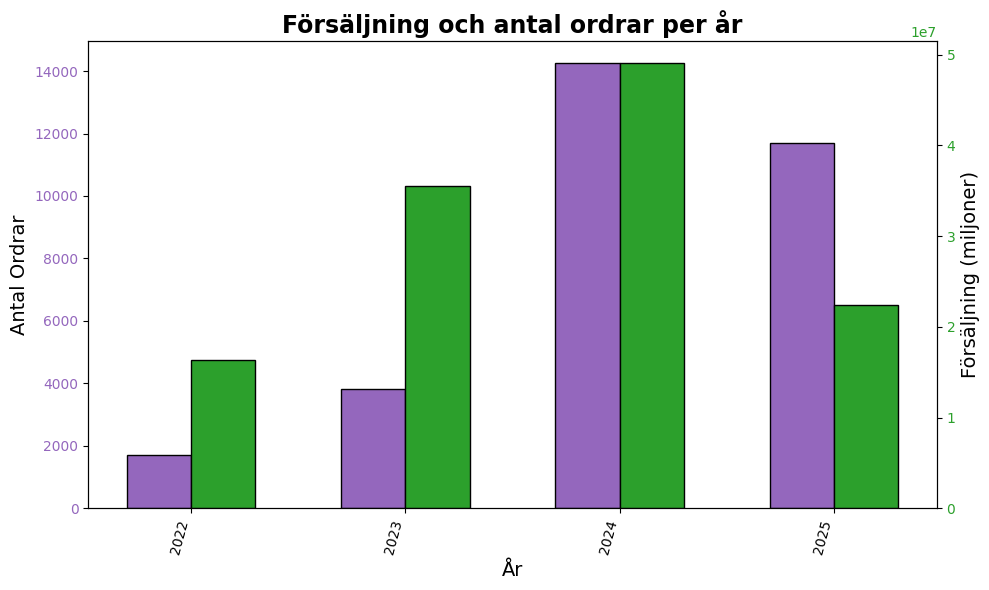

In [57]:
query_vis4 = """ 
SELECT
    YEAR(OrderDate) AS Year,
    COUNT(SalesOrderID) AS Orders,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate) 
ORDER BY Year ASC
"""

df_vis4 = query_df(query_vis4)

idx = np.arange(len(df_vis4["Year"]))
width = 0.3

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

bar_orders = ax1.bar(idx - width/2, df_vis4["Orders"], width, label="Antal Ordrar", color="tab:purple", edgecolor="black")
bar_totalsales = ax2.bar(idx + width/2, df_vis4["TotalSales"], width, label="Försäljning", color="tab:green", edgecolor="black")


ax1.set_title("Försäljning och antal ordrar per år", fontsize=17, fontweight="bold")
ax1.set_xlabel("År", fontsize=14)
ax1.set_ylabel("Antal Ordrar", fontsize=14)
ax2.set_ylabel("Försäljning (miljoner)", fontsize=14)
ax1.set_xticks(idx)
ax1.set_xticklabels(df_vis4["Year"], rotation=75, ha="right")
ax1.tick_params(axis="y", labelcolor="tab:purple")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.tight_layout()
plt.show()



### Analys - Försäljning och antal ordrar per år

Enligt visualiseringen kan man se att det var flest ordar samt högst försäljning år 2024.  
Som lägst när det kommer till både försäljning och antal ordrar var det 2022.  
Man kan dessvärre se att trenden vänt med åren, att man innan 2024 hade högre försäljning jämfört med antal ordrar men att det 2025 vänder och försäljningen tappar jämfört med antalet ordrar. 

Det kan vara värt att se över vinstmarginaler.